In [1]:
#!pip install catboost

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", 200)

from catboost import CatBoostRegressor

from sklearn.model_selection import train_test_split
#from sklearn.model_selection import RandomizedSearchCV
#from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import RepeatedKFold, cross_val_score, cross_validate

In [3]:
df = pd.read_csv('housing_clean.csv', index_col=0)
df.shape

(2374, 99)

In [4]:
df.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
Index: 2374 entries, 224 to 648
Data columns (total 99 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   PID                   2374 non-null   int64  
 1   GrLivArea             2374 non-null   int64  
 2   SalePrice             2374 non-null   int64  
 3   MSSubClass            2374 non-null   int64  
 4   MSZoning              2374 non-null   object 
 5   LotFrontage           2374 non-null   float64
 6   LotArea               2374 non-null   int64  
 7   Street                2374 non-null   object 
 8   Alley                 118 non-null    object 
 9   LotShape              2374 non-null   object 
 10  LandContour           2374 non-null   object 
 11  Utilities             2374 non-null   object 
 12  LotConfig             2374 non-null   object 
 13  LandSlope             2374 non-null   object 
 14  Neighborhood          2374 non-null   object 
 15  BldgType              237

### Remove original columns that have been ordinalized

In [5]:
df = df.drop(columns=[col for col in df.columns if col.endswith('_todrop')])

### Drop Features due to perfect multicollinearity
- Not required for tree-based model but it improves efficiency by having fewer features and interpretability (the feature importance scores will be split among all of the features with perfect multicollinearity).

In [6]:
multi_todrop = ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt',
               '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
                'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF'
               ]

In [7]:
df = df.drop(multi_todrop, axis = 1)

### Handle nominal features
- For CatBoost, we don't need to dummify nominal features
- We do need to covert all nominal feature columns into string data type
- Better to do this before train / test split

In [8]:
categ_nom = ['MSSubClass','BldgType','HouseStyle','SaleType','SaleCondition','MiscFeature',
             'Fence','GarageType','RoofStyle','RoofMatl','exterior_covering','MasVnrType',
             'MSZoning','Street','LotShape','LandContour','LotConfig','LandSlope','Neighborhood',
             'Alley','condition','Foundation','Utilities','Heating',
             'CentralAir','MoSold','Electrical','QrtSold']

In [9]:
# check data type for each nominal feature
print(df[categ_nom].dtypes)

MSSubClass            int64
BldgType             object
HouseStyle           object
SaleType             object
SaleCondition        object
MiscFeature          object
Fence                object
GarageType           object
RoofStyle            object
RoofMatl             object
exterior_covering    object
MasVnrType           object
MSZoning             object
Street               object
LotShape             object
LandContour          object
LotConfig            object
LandSlope            object
Neighborhood         object
Alley                object
condition            object
Foundation           object
Utilities            object
Heating              object
CentralAir           object
MoSold                int64
Electrical           object
QrtSold              object
dtype: object


In [10]:
# turn all nominal features into string type so it can be passed in cat_features argument later
df[categ_nom] = df[categ_nom].astype(str)

In [11]:
print(df[categ_nom].dtypes)

MSSubClass           object
BldgType             object
HouseStyle           object
SaleType             object
SaleCondition        object
MiscFeature          object
Fence                object
GarageType           object
RoofStyle            object
RoofMatl             object
exterior_covering    object
MasVnrType           object
MSZoning             object
Street               object
LotShape             object
LandContour          object
LotConfig            object
LandSlope            object
Neighborhood         object
Alley                object
condition            object
Foundation           object
Utilities            object
Heating              object
CentralAir           object
MoSold               object
Electrical           object
QrtSold              object
dtype: object


### Perform Train / Test Split
- I used the data from 2006 to 2009 for training and 2010 for testing because it mimics a real-world scenario perfectly. It ensures my model is being evaluated on its ability to predict future, unseen data.
- I also dropped column 'YrSold' when training the data because the model might learn that homes sold in 2010 have a particular characteristic that is a direct result of the year itself (e.g., a general market trend or a single large event), rather than a true feature of the house. This makes the model less generalizable to future years. Features that have been derived from 'YrSold' such as 'age_at_sale', 'years_since_remod' and 'garage_age_derived' are directly related to the house, not the time of the market and it also avoids data leakage from the year itself.

In [12]:
X = df.drop(['SalePrice', 'PID', 'YrSold'], axis = 1)
y = df['SalePrice']

In [13]:
# Split the data into train and test based on the year the house was sold
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

X_train = df.loc[df['YrSold'].astype(int).between(2006, 2009)].drop(['SalePrice', 'PID', 'YrSold'], axis = 1)
X_test = df.loc[df['YrSold'].astype(int) == 2010].drop(['SalePrice', 'PID', 'YrSold'], axis = 1)

y_train = df.loc[df['YrSold'].astype(int).between(2006, 2009)]['SalePrice']
y_test = df.loc[df['YrSold'].astype(int) == 2010]['SalePrice']

### Setting up a baseline model before any tuning

* **Set a fair baseline:** Train a plain (untuned) model to get a reference R² you can compare against after tuning.
* **Reduce split luck:** Repeat cross validation multiple times for the training dataset and **average** the R² so your baseline isn’t driven by a single “easy” or “hard” split.
* **Isolate variability:** Fix the model’s `random_state` so differences come from the **data splits**, not extra model randomness.
* **Make comparisons honest:** Report mean ± std of train/test R² from these repeats; tuning “wins” only if it beats this baseline by more than the noise.

In [14]:
model_baseline = CatBoostRegressor(
    cat_features=categ_nom,
    verbose=0,  # Suppress training output
    random_state=42)

In [15]:
model_baseline.fit(X_train, y_train)

In [16]:
# evaluate untuned / baseline model
y_train_pred = model_baseline.predict(X_train)
y_test_pred = model_baseline.predict(X_test)

# R2
r2_baseline_train = model_baseline.score(X_train, y_train)
r2_baseline_test = model_baseline.score(X_test, y_test)

print(f"Train R square: {r2_baseline_train:.4f}")
print(f"Test R square: {r2_baseline_test:.4f}")

# root mean squared error, lower is better
# sensitive to outliers
# tells you the average size of the error in prediction — in dollar terms
rmse_baseline_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_baseline_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"Train Root Mean Squared Error: {rmse_baseline_train:.2f}")
print(f"Test Root Mean Squared Error: {rmse_baseline_test:.2f}")

Train R square: 0.9864
Test R square: 0.9252
Train Root Mean Squared Error: 8818.15
Test Root Mean Squared Error: 20329.04


In [17]:
# Implementing Repeated K-Fold Cross-Validation (before tuning any hyperparameters)

n_splits = 5
n_repeats = 3
rkf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=42)

# Initialize baseline model
model = CatBoostRegressor(
    cat_features=categ_nom,
    verbose=0,  # Suppress training output
    random_state=42)

# Lists to store the scores and RMSE values
scores = []
rmse_values = []

# Perform the cross-validation on the TRAINING data
for train_index, val_index in rkf.split(X_train):
    # Split the training data into internal training and validation sets
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    # Train the model on the training fold
    model.fit(X_train_fold, y_train_fold)

    # Evaluate the model on the validation fold
    score = model.score(X_val_fold, y_val_fold)
    scores.append(score)
    
    # Calculate RMSE manually
    y_pred_val = model.predict(X_val_fold)
    rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred_val))
    rmse_values.append(rmse)

# Calculate the average score
average_score = np.mean(scores)
average_rmse = np.mean(rmse_values)
std_rmse = np.std(rmse_values)

print(f"Average baseline R-squared score: {average_score:.4f}")
print(f"Average baseline RMSE: ${average_rmse:.2f}")
print(f"Standard deviation of RMSE: ${std_rmse:.2f}")

Average baseline R-squared score: 0.9290
Average baseline RMSE: $19947.27
Standard deviation of RMSE: $3317.27


## Hyperparameter Tuning

### First, trying RandomizedSearchCV to find the best model
- The best R squared found is 86%, not ideal

In [18]:
# param_grid = {
#     "iterations": [500, 800, 1000],
#     "depth": [4, 6, 8],
#     "learning_rate": [0.01, 0.05, 0.1],
#     "l2_leaf_reg": [1, 3, 5],
#     "bagging_temperature": [0.5, 1, 2],
#     "border_count": [32, 64, 128]
# }

In [19]:
# random_search = RandomizedSearchCV(
#     estimator=model,
#     param_distributions=param_grid,
#     n_iter=20,                # number of random combos to try
#     #scoring='neg_root_mean_squared_error',
#     scoring='r2',
#     cv=5,
#     random_state=42,
#     n_jobs=-1,
#     verbose=0
# )

# random_search.fit(X_train, y_train)

# print("Best CV R-squared:", random_search.best_score_)
# print("Best Parameters:", random_search.best_params_)

### Secondly, experimenting with Optuna

In [20]:
#!pip install optuna

In [21]:
import optuna
from optuna.samplers import TPESampler

In [60]:
# It's a good practice to set up logging to see Optuna's progress
optuna.logging.set_verbosity(optuna.logging.INFO)

#X_tra, X_val, y_tra, y_val
#def objective(trial, X_tra, X_val, y_tra, y_val):
def objective(trial):
    """
    This function defines the search space for Optuna. It suggests hyperparameters,
    trains the model on the training set, evaluates it on the validation set, and returns
    a single value to be optimized (R-squared score).

    Args:
        trial (optuna.trial.Trial): The trial object that suggests hyperparameters.

    Returns:
        float: The R-squared score on the validation set.
    """
    # Define the search space for the hyperparameters using trial.suggest_...
#     param = {
#         # 'iterations': The number of boosting iterations (trees).
#         # if removed, it simplifies the problem 
#         'iterations': trial.suggest_int('iterations', 500, 1500, step=100),
        
#         # 'depth': The depth of the trees.
#         'depth': trial.suggest_int('depth', 4, 10),
        
#         # 'min_data_in_leaf': stop splitting a node if the resulting child nodes would have fewer than this 
#         # minimum number of data points
#         'min_data_in_leaf': trial.suggest_int("min_data_in_leaf", 2, 20),
        
#         # 'learning_rate': The step size shrinkage.
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        
#         # 'l2_leaf_reg': The L2 regularization coefficient.
#         'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        
#         # 'one_hot_max_size': If a categorical feature has a number of unique values that is less than or equal to the
#         # this threshold, CatBoost wil perfomr on-hot encoding. If the number of unique values is greater,
#         # CatBoost will use its native, more advanced methods for processing the feature
#         'one_hot_max_size': trial.suggest_int("one_hot_max_size", 2, 20), 
        
#         # 'bagging_temperature': The bagging temperature for feature subsampling.
#         # doesn't seem to drive hyperparameter optimization after first try
#         #'bagging_temperature': trial.suggest_float('bagging_temperature', 0.5, 5),
        
#         # 'border_count': specifies the maximum number of bins that will be created for 
#         # each numerical feature. CatBoost doesn't consider every single unique value of a feature as a potential
#         # split point, instead, it groups the feature values into a limited number of 'bins' and only considers the
#         # boundaries of these bins as potential split points
#         'border_count': trial.suggest_int('border_count', 32, 255),
        
#         # 'random_seed': Use a fixed seed for reproducibility across trials.
#         'random_seed': 42,
#         'verbose': 0
#     }

    param = {
        # 'iterations': Keep this range, but a lower learning rate may require more iterations.
        'iterations': trial.suggest_int('iterations', 500, 1500, step=100),

        # 'depth': We've reduced the max depth to make the trees simpler.
        'depth': trial.suggest_int('depth', 4, 8),

        # 'min_data_in_leaf': We've increased the minimum to prevent overly specific leaves.
        'min_data_in_leaf': trial.suggest_int("min_data_in_leaf", 5, 20),

        # 'learning_rate': This range is good; the model will find a balance with iterations.
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),

        # 'l2_leaf_reg': The range is still solid, but feel free to experiment with a higher lower bound.
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),

        # 'one_hot_max_size': This is a good range to explore for your categorical features.
        'one_hot_max_size': trial.suggest_int("one_hot_max_size", 2, 20),

        # 'bagging_temperature': Added back to introduce more randomness and prevent overfitting.
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.5, 5),

        'border_count': trial.suggest_int('border_count', 32, 255),
        'random_seed': 42,
        'verbose': 0
    }

    # Initialize the CatBoost Regressor with the parameters suggested by the trial
    model = CatBoostRegressor(**param, cat_features=categ_nom)

    
    # Implementing Repeated K-Fold Cross-Validation
    n_splits = 5
    n_repeats = 3
    rkf = RepeatedKFold(n_splits=n_splits,n_repeats=n_repeats,random_state=42) 
    
    r2_scores = []
    
    for train_index, val_index in rkf.split(X_train):
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
    
    
    
    # Train the model on the training data.
    # We use the test set as the evaluation set to allow for early stopping,
    # which can prevent overfitting and save time.
    model.fit(X_train_fold, y_train_fold, eval_set=[(X_val_fold, y_val_fold)], early_stopping_rounds=50, verbose=0)

    # Make predictions on the validation data
    y_pred = model.predict(X_val_fold)
    
    # Calculate the R-squared score on the validation set
    r2 = r2_score(y_val_fold, y_pred)
    r2_scores.append(r2)

    # Optuna needs a single value to optimize, so we return the R-squared score
    return np.mean(r2_scores)

In [61]:
# --- Create the Optuna study and run the optimization ---
# We want to maximize the R-squared score, so we set direction='maximize'
# We explicitly use TPESampler as requested.
study = optuna.create_study(
    direction='maximize',
    sampler=TPESampler(seed=42)
)

print("Starting Optuna optimization for hyperparameter tuning...")
# Run the optimization for a specified number of trials.
# We use a lambda function to pass the data to the objective function.
#study.optimize(lambda trial: objective(trial, X_train, X_test, y_train, y_test), n_trials=100, show_progress_bar=True)
study.optimize(objective, n_trials=50, show_progress_bar=True)

# --- Print the results ---
print("-" * 30)
print("Optuna optimization completed.")
print(f"Number of finished trials: {len(study.trials)}")
print(f"Best R-squared score found: {study.best_value:.4f}")
print("\nBest parameters found:")
for param, value in study.best_params.items():
    print(f"  {param}: {value}")

[I 2025-09-21 15:40:48,381] A new study created in memory with name: no-name-1d6157bd-ade4-47bb-b83a-1fe87ab6ec3b


Starting Optuna optimization for hyperparameter tuning...


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-09-21 15:40:52,120] Trial 0 finished with value: 0.9335029250250666 and parameters: {'iterations': 900, 'depth': 8, 'min_data_in_leaf': 16, 'learning_rate': 0.060099747183803134, 'l2_leaf_reg': 2.4041677639819286, 'one_hot_max_size': 4, 'bagging_temperature': 0.7613762547568976, 'border_count': 226}. Best is trial 0 with value: 0.9335029250250666.
[I 2025-09-21 15:40:52,722] Trial 1 finished with value: 0.9296283720621846 and parameters: {'iterations': 1100, 'depth': 7, 'min_data_in_leaf': 5, 'learning_rate': 0.18276027831785724, 'l2_leaf_reg': 8.491983767203795, 'one_hot_max_size': 6, 'bagging_temperature': 1.318212352431953, 'border_count': 73}. Best is trial 0 with value: 0.9335029250250666.
[I 2025-09-21 15:40:55,086] Trial 2 finished with value: 0.9295773277943945 and parameters: {'iterations': 800, 'depth': 6, 'min_data_in_leaf': 11, 'learning_rate': 0.023927528765580644, 'l2_leaf_reg': 6.506676052501415, 'one_hot_max_size': 4, 'bagging_temperature': 1.8146509184084816, '

[I 2025-09-21 15:41:20,982] Trial 23 finished with value: 0.9359454860502694 and parameters: {'iterations': 1400, 'depth': 5, 'min_data_in_leaf': 17, 'learning_rate': 0.1937877895638567, 'l2_leaf_reg': 8.762328092625136, 'one_hot_max_size': 20, 'bagging_temperature': 1.2293083826314128, 'border_count': 53}. Best is trial 8 with value: 0.9388708482736747.
[I 2025-09-21 15:41:21,582] Trial 24 finished with value: 0.9297776690883848 and parameters: {'iterations': 1300, 'depth': 6, 'min_data_in_leaf': 19, 'learning_rate': 0.0667891375390612, 'l2_leaf_reg': 8.202840787123138, 'one_hot_max_size': 17, 'bagging_temperature': 2.2914724219252953, 'border_count': 125}. Best is trial 8 with value: 0.9388708482736747.
[I 2025-09-21 15:41:22,301] Trial 25 finished with value: 0.9273494018595458 and parameters: {'iterations': 1500, 'depth': 6, 'min_data_in_leaf': 15, 'learning_rate': 0.16098622951899152, 'l2_leaf_reg': 9.168529536151361, 'one_hot_max_size': 6, 'bagging_temperature': 1.696148271427622

[I 2025-09-21 15:41:53,535] Trial 46 finished with value: 0.9323152587370789 and parameters: {'iterations': 1200, 'depth': 7, 'min_data_in_leaf': 20, 'learning_rate': 0.06982243552689602, 'l2_leaf_reg': 5.430375059991777, 'one_hot_max_size': 10, 'bagging_temperature': 2.6465134153135432, 'border_count': 74}. Best is trial 8 with value: 0.9388708482736747.
[I 2025-09-21 15:41:54,034] Trial 47 finished with value: 0.9361695921217568 and parameters: {'iterations': 600, 'depth': 5, 'min_data_in_leaf': 18, 'learning_rate': 0.10555433274745443, 'l2_leaf_reg': 8.030618503660062, 'one_hot_max_size': 15, 'bagging_temperature': 3.481653798116284, 'border_count': 254}. Best is trial 8 with value: 0.9388708482736747.
[I 2025-09-21 15:41:55,191] Trial 48 finished with value: 0.9327284452854006 and parameters: {'iterations': 1500, 'depth': 4, 'min_data_in_leaf': 12, 'learning_rate': 0.02106540299940216, 'l2_leaf_reg': 6.803426350321594, 'one_hot_max_size': 13, 'bagging_temperature': 4.38371908972871

In [62]:
study.best_params

{'iterations': 800,
 'depth': 6,
 'min_data_in_leaf': 7,
 'learning_rate': 0.11058146376563001,
 'l2_leaf_reg': 1.6709557931179373,
 'one_hot_max_size': 20,
 'bagging_temperature': 3.9751014618349583,
 'border_count': 76}

### Hyperparameter Importances Plot
- This plot shows you which hyperparameters were most influential in determining the model's performance during the optimization process. The importance is calculated by analyzing how much each parameter's value impacted the final R-squared score.

- Essentially, if a hyperparameter like learning_rate or depth has a high importance score, it means that changes to its value led to significant changes in the model's performance. Conversely, a parameter with a low importance score means that varying its value didn't have much effect on the final outcome.

- This plot is incredibly useful for refining your next optimization. For instance, if you see that a certain hyperparameter has very low importance, you might be able to fix its value or remove it from the search space in a future run to make the optimization faster and more efficient.

In [63]:
optuna.visualization.plot_param_importances(study)

### Optimization History Plot
- This plot helps you understand if your optimization is making good progress or if it has reached its full potential.

- Trial-by-Trial Performance: Each dot on the plot represents a single trial (one set of hyperparameters) and its corresponding objective value (the R-squared score in your case). This shows you how the model performed with different parameter combinations.

- Progress Over Time: The x-axis represents the trial number. As you move from left to right, you can see how the performance of the trials changes over the course of the optimization.

- Convergence: The most important part of this plot is the "best value so far" line. This line shows the highest R-squared score found up to each trial. If this line starts to flatten out and doesn't improve much over the last few trials, it's a strong indicator that the optimization has converged. This can tell you that running more trials might not be necessary to find a better solution.

In [64]:
optuna.visualization.plot_optimization_history(study)

### Run Repeated K-fold cross-validation on the entire dataset with the best hyperparameters
- By running K-fold cross-validation on the entire dataset with the best hyperparameters, you are training and evaluating the model on multiple different data splits. The average score across all folds gives you a much more robust and less optimistic R-squared value that better reflects the model's true generalization performance. It essentially removes the bias of a single train/test split.

In [65]:
# --- Cross-Validation with Final Model ---
print("\n" + "="*50)
print("Performing K-fold Cross-Validation with the Final Model...")
print("="*50)

# Re-instantiate the final model with best parameters
final_model = CatBoostRegressor(
    **study.best_params, 
    cat_features=categ_nom,
    verbose=0,
    random_seed=42
)

# Implementing Repeated K-Fold Cross-Validation

n_splits = 5
n_repeats = 3
rkf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=42)

scoring = {'r2': 'r2',
           'neg_RMSE': 'neg_root_mean_squared_error'
          }


# Perform cross-validation and get the R-squared scores
# We use the full dataset (X, y) for cross-validation
cv_scores = cross_validate(final_model, X, y, cv=rkf, scoring=scoring, n_jobs=-1)

# Print the results for each metric
print("\nCross-Validation Results:")
for metric_name, score_array in cv_scores.items():
    if metric_name.startswith('test_'):
        display_name = metric_name.replace('test_', '')
        print(f"  Validation {display_name} scores: {np.round(score_array, 4)}")
        print(f"  Mean Validation {display_name} score: {np.mean(score_array):.4f}")
        print(f"  Standard deviation of {display_name} score: {np.std(score_array):.4f}")
        print("-" * 30)


Performing K-fold Cross-Validation with the Final Model...

Cross-Validation Results:
  Validation r2 scores: [0.9522 0.9246 0.9368 0.9544 0.8776 0.9332 0.9396 0.892  0.9211 0.9391
 0.9263 0.9473 0.9424 0.9369 0.8907]
  Mean Validation r2 score: 0.9276
  Standard deviation of r2 score: 0.0225
------------------------------
  Validation neg_RMSE scores: [-17851.7327 -22310.676  -17265.4288 -16144.5662 -23867.5196 -20880.0266
 -17956.8722 -24609.6455 -21480.0983 -17548.509  -21116.752  -15419.8169
 -19248.4998 -19687.5904 -23837.9296]
  Mean Validation neg_RMSE score: -19948.3776
  Standard deviation of neg_RMSE score: 2819.3342
------------------------------


In [66]:
cv_scores.items()

dict_items([('fit_time', array([2.78780913, 2.70366192, 2.582093  , 3.38575172, 2.66869187,
       2.79451394, 2.5243361 , 2.66088033, 2.56258202, 2.50985909,
       2.42318892, 2.53142977, 2.5278852 , 2.44903493, 2.37900805])), ('score_time', array([0.00905395, 0.00929904, 0.02043104, 0.01329803, 0.01429009,
       0.02862501, 0.00586987, 0.00778174, 0.00539875, 0.00710607,
       0.01238608, 0.00390816, 0.00293469, 0.00434422, 0.0060606 ])), ('test_r2', array([0.95221523, 0.92462466, 0.93683352, 0.9544052 , 0.87761603,
       0.93324703, 0.93958656, 0.89202743, 0.92107831, 0.93907101,
       0.926258  , 0.94728019, 0.94244289, 0.93692201, 0.89071026])), ('test_neg_RMSE', array([-17851.7327101 , -22310.67604177, -17265.42881519, -16144.56623665,
       -23867.51961483, -20880.02655504, -17956.87222013, -24609.64549486,
       -21480.09829275, -17548.50903654, -21116.75203168, -15419.81688996,
       -19248.49976512, -19687.59036527, -23837.92960347]))])

In [67]:
pd.DataFrame(cv_scores).describe()

,fit_time,score_time,test_r2,test_neg_RMSE
count,15.000000,15.000000,15.000000,15.000000
mean,2.632715,0.010052,0.927621,-19948.377578
std,0.242309,0.006959,0.023283,2918.288109
min,2.379008,0.002935,0.877616,-24609.645495
25%,2.517098,0.005634,0.922851,-21895.387167
50%,2.562582,0.007782,0.936834,-19687.590365
75%,2.686177,0.012842,0.941015,-17700.120873
max,3.385752,0.028625,0.954405,-15419.816890


In [68]:
# Get the mean R-squared from the cross-validation results
cv_r2_mean = np.mean(cv_scores['test_r2'])

### Evaluate on Test Set

In [69]:
# Retrain the model using the best hyperparameters found by Optuna
final_model = CatBoostRegressor(
    **study.best_params, 
    cat_features=categ_nom,
    verbose=0,
    random_seed=42
)

final_model.fit(X_train, y_train)

In [70]:
# root mean squared error, lower is better
# sensitive to outliers
# tells you the average size of the error in prediction — in dollar terms

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)

final_rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
final_rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"Final RMSE on the train set: ${final_rmse_train:.4f}")
print(f"Final RMSE on the test set: ${final_rmse_test:.4f}")

# R2
r2_5kf_train = final_model.score(X_train, y_train)
r2_5kf_test = final_model.score(X_test, y_test)

print(f"Train R square: {r2_5kf_train:.4f}")
print(f"Test R square: {r2_5kf_test:.4f}") 

Final RMSE on the train set: $3800.5106
Final RMSE on the test set: $19365.7875
Train R square: 0.9975
Test R square: 0.9321


### Extract Feature Importance

In [71]:
feature_importance_final = pd.DataFrame({"feature": X.columns, 
                                            "importance_cb_5fk":final_model.feature_importances_})

In [72]:
feature_importance_final.sort_values("importance_cb_5fk", ascending = False, inplace=True);
feature_importance_final.head(10)

,feature,importance_cb_5fk
0,GrLivArea,21.623930
15,OverallQual,19.136408
22,TotalBsmtSF,6.455138
58,BsmtQual_ordinal,5.796540
64,ExterQual_ordinal,3.396850
4,LotArea,2.876300
57,KitchenQual_ordinal,2.866967
33,Fireplaces,2.788490
34,GarageType,1.899982
3,LotFrontage,1.889341


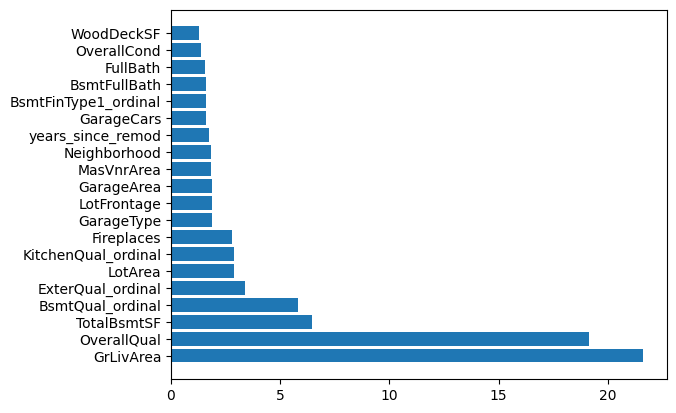

In [73]:
temp = feature_importance_final.iloc[:20,]
plt.barh(temp["feature"], temp["importance_cb_5fk"]);

## Model Evaluation

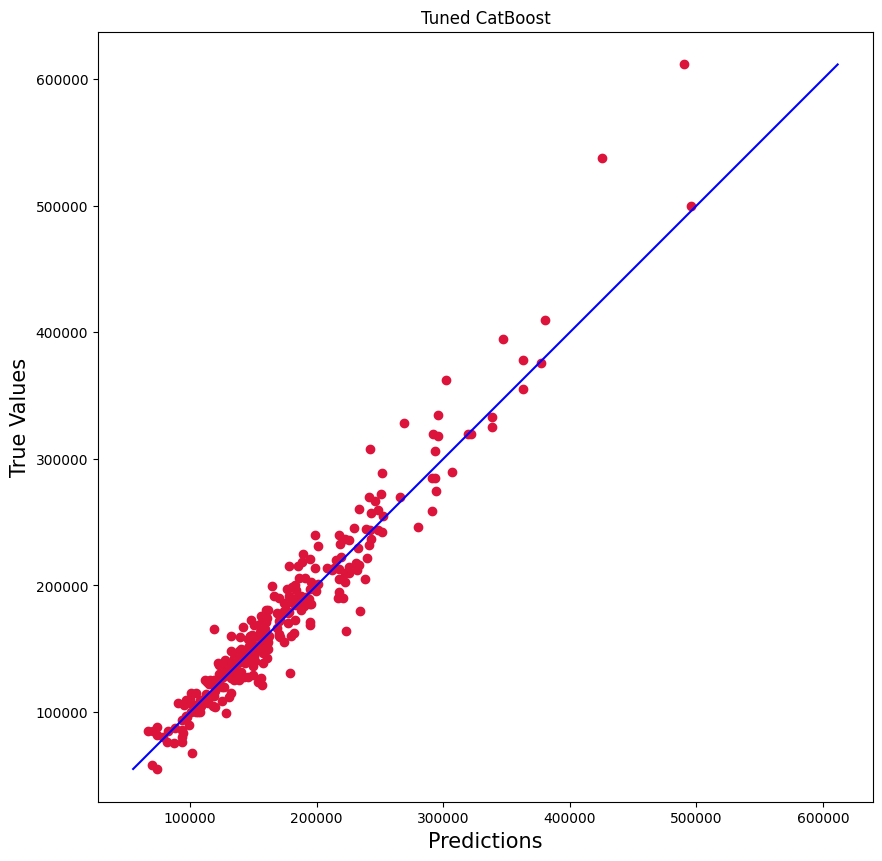

In [74]:
# Plot y_test vs y_test_pred

plt.figure(figsize=(10,10))
plt.scatter(y_test_pred, y_test, c='crimson')

plt.title('Tuned CatBoost')
p1 = max(max(y_test_pred), max(y_test))
p2 = min(min(y_test_pred), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('Predictions', fontsize=15)
plt.ylabel('True Values', fontsize=15)
plt.axis('equal')
plt.show()

### Residual Plot
- After training your final CatBoost model and using it to make predictions on the test set, you can generate a residual plot to visually inspect its performance. This type of plot is a valuable tool for understanding if your model's errors are random or if there are systematic patterns.

- The plot below shows the relationship between your model's predicted values and the residuals (the difference between the actual and predicted values).

- An ideal residual plot will show a random, uniform scatter of points around the horizontal line at y=0. This indicates that your model's errors are random and are not related to the predicted value. It means your model is not systematically over- or under-predicting for certain ranges of house prices.

- In contrast, if you see a discernible pattern in the plot (e.g., a fanning-out shape, a curve, or a clear concentration of points), it suggests that your model may have a bias. For example, a fanning-out pattern could mean that the model's errors increase as the predicted price gets higher, indicating a need for a more complex model or additional features to handle higher-priced homes.

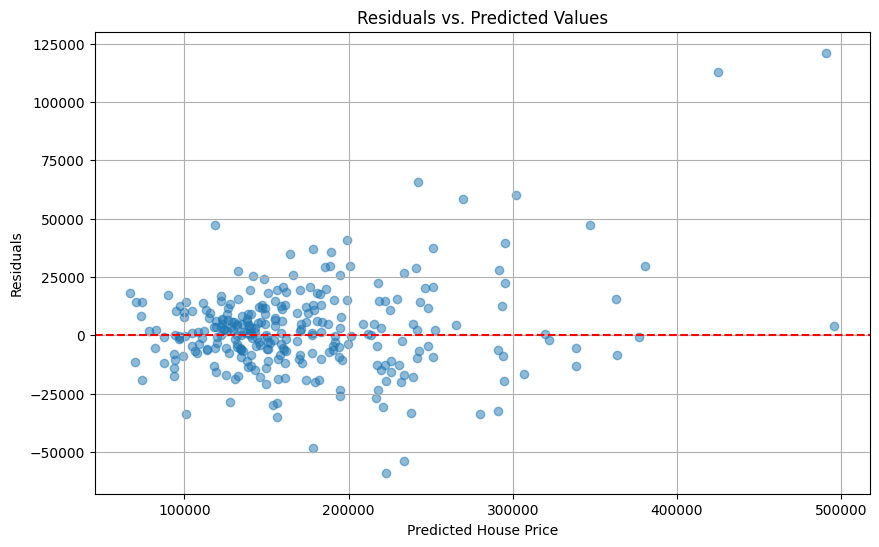

In [75]:
# Plot Residuals vs. Predicted Values

residuals = y_test - y_test_pred

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test_pred, residuals, alpha=0.5)
plt.title('Residuals vs. Predicted Values')
plt.xlabel('Predicted House Price')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.grid(True)
plt.show()
#plt.savefig('residuals_plot.png')

#print("Residuals plot has been generated and saved as 'residuals_plot.png'.")

### Distribution of actual house prices, y_test and y_test_pred
- Overlap: The more the two distributions overlap, the better your model's predictions align with the actual values. An ideal model's y_pred distribution will closely mimic the y_test distribution.

- Shape: The shapes of the two distributions should be similar. If the y_pred distribution is much narrower than the y_test distribution, it means your model is under-predicting the range of prices and is not confident in making predictions for the highest or lowest-priced homes.

- Skewness: If the actual data is skewed (e.g., towards higher prices), your predicted data should show a similar skew.

In [76]:
# Calculate the mean and standard deviation
y_test_mean = np.mean(y_test)
y_test_std = np.std(y_test)
y_test_pred_mean = np.mean(y_test_pred)
y_test_pred_std = np.std(y_test_pred)

print("Actual Values (y_test) statistics:")
print(f"Mean: {y_test_mean:.4f}")
print(f"Standard Deviation: {y_test_std:.4f}")
print("\nPredicted Values (y_test_pred) statistics:")
print(f"Mean: {y_test_pred_mean:.4f}")
print(f"Standard Deviation: {y_test_pred_std:.4f}")

Actual Values (y_test) statistics:
Mean: 174699.6007
Standard Deviation: 74329.6605

Predicted Values (y_test_pred) statistics:
Mean: 172382.0699
Standard Deviation: 67349.8401


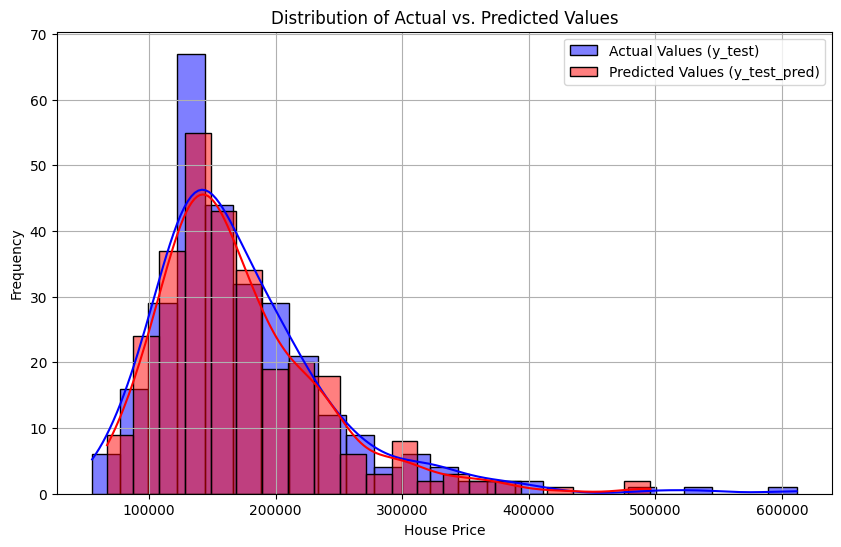

In [77]:
# Plot the distributions of y_test and y_test_pred
plt.figure(figsize=(10, 6))
sns.histplot(y_test, kde=True, color='blue', label='Actual Values (y_test)')
sns.histplot(y_test_pred, kde=True, color='red', label='Predicted Values (y_test_pred)')
#sns.histplot(y, kde=True, color='orange', label='Sales Prices (y)')

plt.title('Distribution of Actual vs. Predicted Values')
plt.xlabel('House Price')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()
#plt.savefig('distribution_plot.png')

#print("Distribution plot has been generated and saved as 'distribution_plot.png'.")

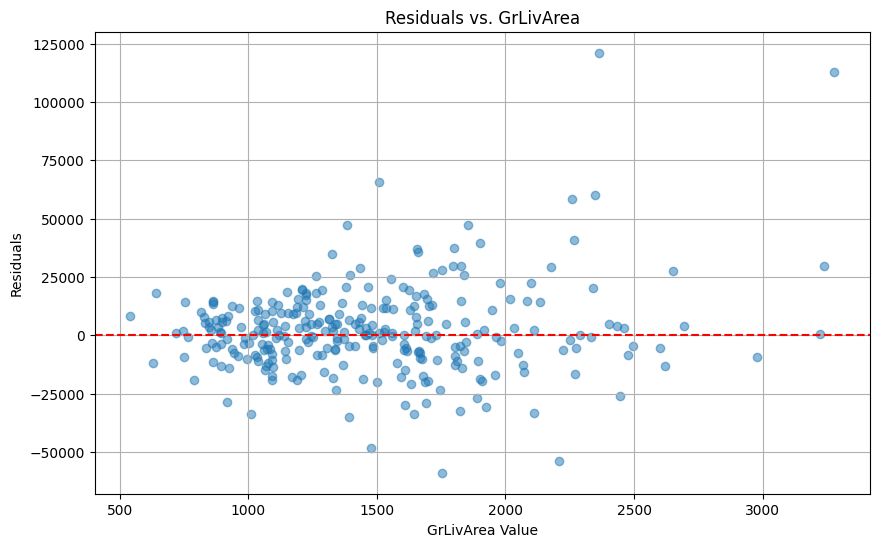

In [78]:
# plot residual vs features

# Choose the feature you want to plot against
feature_to_plot = 'GrLivArea'  # Change this to your desired feature (e.g., 'GrLivArea')
feature_values = X_test[feature_to_plot]

# Create the scatter plot of residuals vs. a chosen feature
plt.figure(figsize=(10, 6))
plt.scatter(feature_values, residuals, alpha=0.5)
plt.title(f'Residuals vs. {feature_to_plot}')
plt.xlabel(f'{feature_to_plot} Value')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.grid(True)
plt.show()
#plt.savefig(f'residuals_vs_{feature_to_plot}.png')

#print(f"Residuals vs. {feature_to_plot} plot has been generated and saved.")

## Model Explainability

### SHAP
- A SHAP value tells you how much a particular feature pushes the model’s predicted house price up or down, compared to the average prediction across the dataset.

In [41]:
# Say the average predicted price is $200,000
# If for House A, the SHAP value for GrLivArea is +15,000, 
# that means the model believes the GrLivArea of House A contributes +$15,000 to the price, 
# compared to the average. If for House B, the SHAP value is -5,000, 
# that means the GrLivArea of House B is lowering the prediction by $5,000 from the average.

In [79]:
import shap

# Fit explainer on train data
explainer = shap.Explainer(final_model)

# Evaluate SHAP values on test set
shap_values = explainer.shap_values(X_test)

#This balances accurate attribution with realistic performance evaluation.

In [80]:
# SHAP feature importance
mean_abs_shap_values = np.abs(shap_values).mean(axis=0)

# Create a DataFrame for easier viewing and sorting
shap_importance = pd.DataFrame({
    'feature': X.columns,
    'mean_abs_shap_cb_5fk': mean_abs_shap_values
})

# Sort in descending order
shap_importance_sorted = shap_importance.sort_values(by='mean_abs_shap_cb_5fk', ascending=False)

# Display
print(shap_importance_sorted.head(30))

# how to interpret:
# # On average, the feature GrLivArea changes the model’s prediction by 15,625 units of currency (likely dollars), 
# either increasing or decreasing the predicted house price.

                 feature  mean_abs_shap_cb_5fk
0              GrLivArea          17543.547899
15           OverallQual           9178.092720
22           TotalBsmtSF           6920.382974
57   KitchenQual_ordinal           3815.031735
16           OverallCond           3729.114305
4                LotArea           3696.623854
66     HeatingQC_ordinal           3442.348736
69     years_since_remod           3414.627030
61  BsmtFinType1_ordinal           3369.564766
33            Fireplaces           3097.755868
26          BsmtFullBath           2947.100688
12          Neighborhood           2581.045712
68           age_at_sale           2343.778970
36            GarageArea           2233.470099
58      BsmtQual_ordinal           2156.913517
37            WoodDeckSF           2083.234229
64     ExterQual_ordinal           2055.198914
28              FullBath           1959.016561
60  BsmtExposure_ordinal           1894.778543
54   FireplaceQu_ordinal           1619.341531
34           

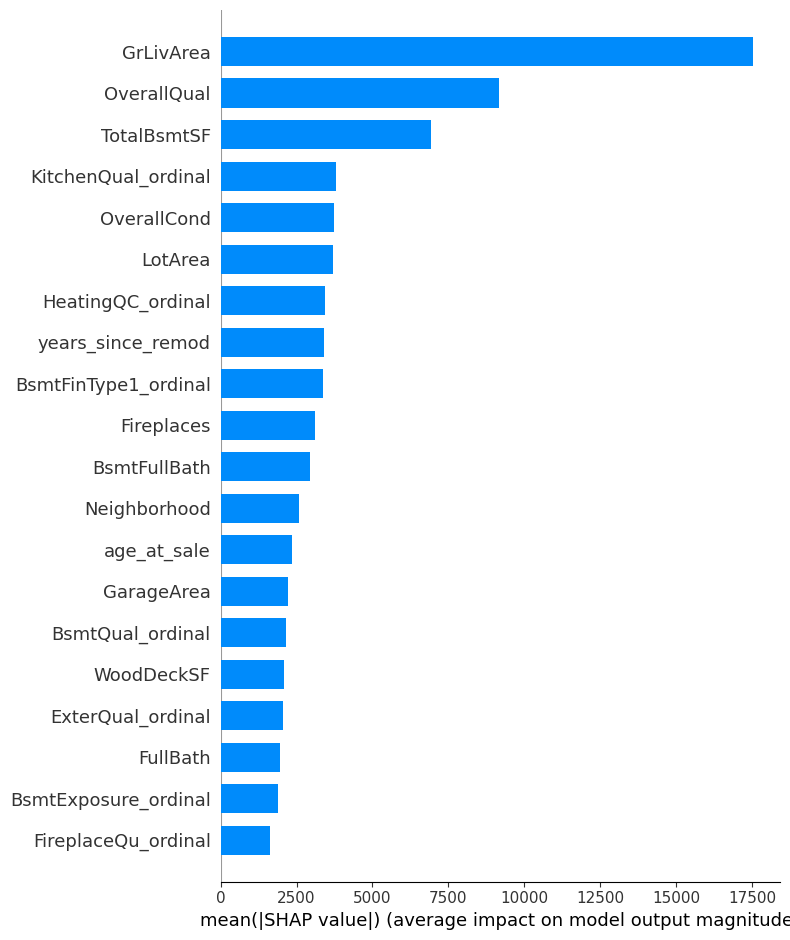

In [81]:
# to visualize the mean abs of SHAP value using summary bar plot
shap.summary_plot(shap_values, X_test, plot_type='bar')

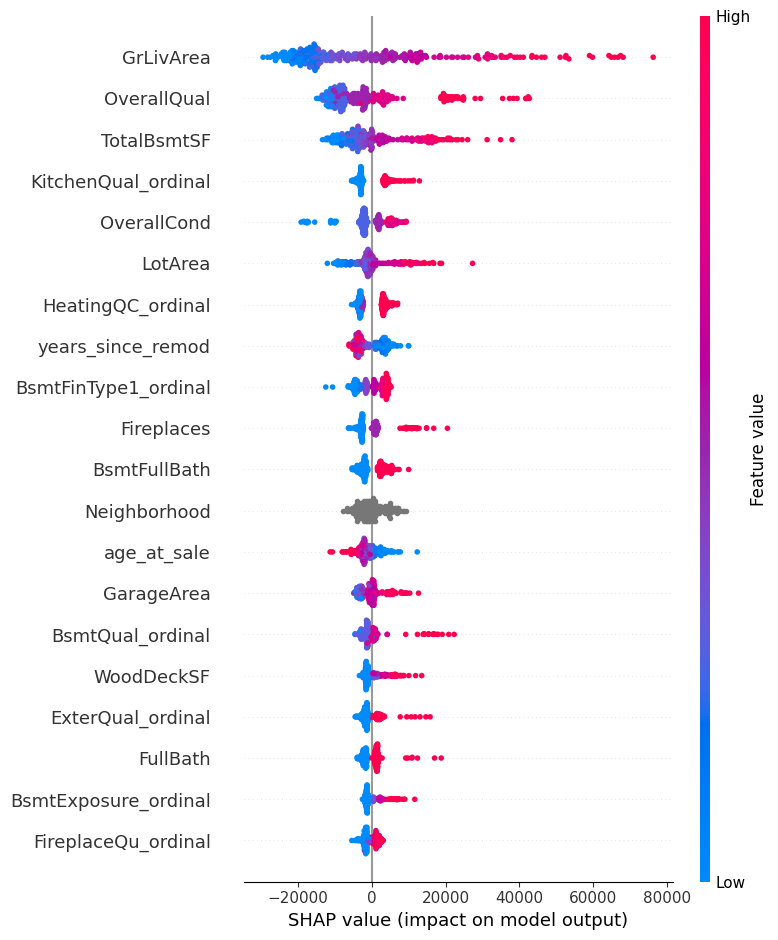

In [82]:
# summary violin plot
shap.summary_plot(shap_values, X_test)

In [46]:
# How to Read the Violin Plot
# ✅ 1. Width of the Violin (Horizontal Spread)

# Wider areas indicate more data points with similar SHAP values.

# This shows the distribution of how much that feature affects predictions across your dataset.

# ✅ 2. Color Gradient (Red → Blue)

# Each dot is colored by the actual value of the feature:

# Red = High feature value

# Blue = Low feature value

# This helps you understand the direction of the effect.

# For example, if red dots are mostly on the right (positive SHAP values), high values of that feature increase the prediction (e.g., higher price).

# If blue dots are on the left (negative SHAP values), low values decrease the prediction.

# ✅ 3. X-Axis (SHAP Value)

# Represents the magnitude and direction of impact on the model’s prediction.

# A value of +5000 means the feature adds $5,000 (for a house price model).

# A value of -3000 means it subtracts $3,000 from the prediction.

### SHAP Dependence Plot
- In a SHAP dependence plot, the x-axis shows the value of the feature you specified, and the y-axis shows the SHAP value (i.e., the feature’s contribution to the model output). But if you’re seeing a second feature encoded on the plot, that’s expected and by design. The second feature (by color) is there to show interactions. The SHAP dependence plot automatically colors the points by the most correlated feature with the one on the x-axis. This helps uncover interactions between features.

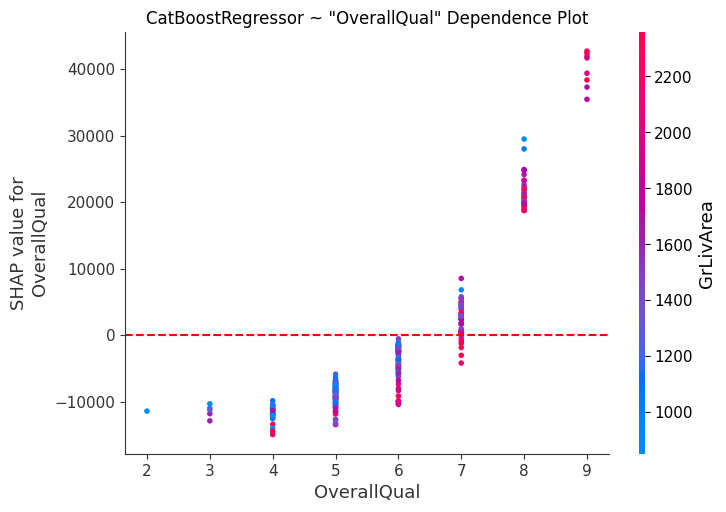

In [114]:
shap.dependence_plot('OverallQual', shap_values, X_test, show=False)

plt.tight_layout()
plt.axhline(y=0, color='red', linestyle='--')
plt.title('CatBoostRegressor ~ "OverallQual" Dependence Plot')
plt.savefig('shap_dep_plot_OverallQual_cb.png', bbox_inches='tight', dpi=300)

# if don't want to show the second y-axis
#shap.dependence_plot('GrLivArea', shap_values, x_test, interaction_index=None)

In [117]:
shap_importance_sorted.head(20)

,level_0,index,CatBoostRegressor,mean_abs_shap_cb_5fk
0,0,0,GrLivArea,17543.547899
1,1,15,OverallQual,9178.092720
2,2,22,TotalBsmtSF,6920.382974
3,3,57,KitchenQual_ordinal,3815.031735
4,4,16,OverallCond,3729.114305
5,5,4,LotArea,3696.623854
6,6,66,HeatingQC_ordinal,3442.348736
7,7,69,years_since_remod,3414.627030
8,8,61,BsmtFinType1_ordinal,3369.564766
9,9,33,Fireplaces,3097.755868


In [115]:
# Select top 20 features
top_features = shap_importance_sorted.head(20)['feature']

for feature in top_features:
    plt.figure(figsize=(6, 4))  # Compact size
    
    shap.dependence_plot(
        feature,
        shap_values,
        X_test,
        #interaction_index=None,  # Auto-picks a good feature for color encoding
        show=False
    )
    plt.title(f"SHAP Dependency Plot: {feature}")
    plt.tight_layout()
    plt.show()
    
    # Save plot to file
#     filename = f"shap_dependency_{feature}.png"
#     plt.savefig(filename, dpi=150)
#     plt.close()

# how to interpret
# using OverallQual as an example,
# 1stFlrSF is the most correlated feature with Overall
# you can see larger homes with high OverallQual have even higher SHAP values (strong positive synergy).
# Conversely, small homes (blue dots) with high OverallQual may still not be valued as highly.

KeyError: 'feature'

In [85]:
 # 3. SHAP Force Plots (Local Explainability)
print("\n" + "="*50)
print("Generating SHAP Force Plots...")
print("="*50)

# The force plot explains a single prediction. Let's pick the first instance from the test set.
# It shows which features push the prediction higher (red) or lower (blue) than the baseline.
# The baseline value is the average of the model's predictions over the entire dataset.
sample_index = 1

# For a single observation
print(f"\nGenerating force plot for a single instance (index: {sample_index})...")
# `shap.initjs()` is needed for the JavaScript plot to render correctly in notebooks.
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[sample_index, :], X_test.iloc[sample_index, :])

# For the entire dataset (or a large number of samples), a global force plot can be generated.
# This gives an overview of how features affect the predictions across many instances.
#print("\nGenerating force plot for the entire dataset...")
#shap.force_plot(explainer.expected_value, shap_values, X_test)


Generating SHAP Force Plots...

Generating force plot for a single instance (index: 1)...


### Export lists for final model comparison

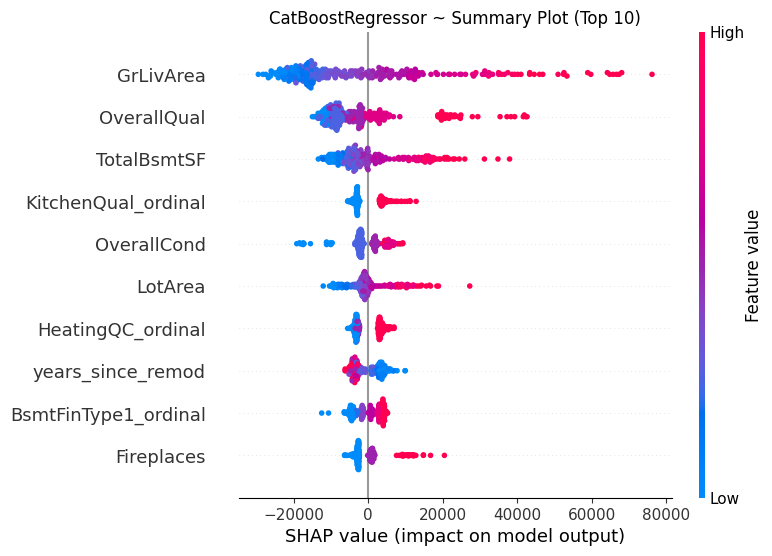

In [113]:
shap.summary_plot(shap_values, X_test, max_display = 10, show=False)
plt.tight_layout()
plt.title('CatBoostRegressor ~ Summary Plot (Top 10)')
plt.savefig('shap_summary_plot_top10_cb.png', bbox_inches='tight', dpi=300)

In [98]:
shap_importance_sorted.drop('index', axis=1).head(5)

,feature,mean_abs_shap_cb_5fk
0,GrLivArea,17543.547899
1,OverallQual,9178.092720
2,TotalBsmtSF,6920.382974
3,KitchenQual_ordinal,3815.031735
4,OverallCond,3729.114305


In [100]:
# export SHAP importance data into a csv
shap_importance_sorted.reset_index(inplace=True)
shap_importance_sorted.to_csv('shap_importance_cb.csv', index=False)

In [102]:
# Create a new DataFrame that includes the best value from the tuning process as well.
# This addresses the user's specific request.
full_comparison = pd.DataFrame({
    'model': ['CatBoost'] * 3,
    'metric': ['Test_R2', 'Best_Tuned_R2', 'Final_CV_mean_R2'],
    'score': [r2_5kf_test, study.best_value, cv_r2_mean]
})

In [103]:
full_comparison

,model,metric,score
0,CatBoost,Test_R2,0.932119
1,CatBoost,Best_Tuned_R2,0.938871
2,CatBoost,Final_CV_mean_R2,0.927621


In [104]:
# export R2 scores into a csv
full_comparison.reset_index(inplace=True)
full_comparison.to_csv('r2_cb.csv', index=False)